# Running Armory Scenarios Interactively [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/twosixlabs/armory/blob/master/notebooks/running_armory_scenarios_interactively.ipynb)

In this tutorial, we'll demonstrate how to run Armory scenarios interactively, export and visualize data examples, and more. We'll use the CARLA object detection scenario as an example, although what follows is instructive for using Armory in general.

To run Armory scenarios interactively, be sure to pass the `--interactive` or `--jupyter` flag when invoking `armory run <CONFIG>`. After doing so, you will receive instructions logged to console on how to attach to the newly launched Docker container. If using the `--jupyter` flag, you'll also receive a URL to open the Jupyter notebook.

If running `armory` locally, you can follow along with this tutorial by running the following command:
`armory run scenario_configs/eval5/carla_object_detection/carla_obj_det_dpatch_undefended.json --jupyter`

If you are executing `armory` in a remote environment- such as Google Colab- be sure to execute the following cell to setup the environment; this process can take between 60 and 240 seconds depending on your network speeds.

In [ ]:
%%bash
# Only execute this cell if you are running this notebook in a
# remote jupyter environment. This process may take some time.

if [ ! -d armory-repo ]; then
  git clone https://github.com/twosixlabs/armory.git armory-repo
fi

pip install --upgrade pip
pip install armory-testbed[pytorch]

### Loading the Scenario
To load the scenario, we use Armory's `get()` function in `armory.scenarios.main`. The filepath used below is an example, and you'll receive the specific path logged to console after invoking `armory run`.

In [19]:
from pathlib import Path

# When launched interactively, or from the container, the scenario config will
# be located in a time-stamped sub-directory of `armory/tmp/`.
# Example:
#    >>> # To run, inside of a notebook:
#    >>>     from armory.scenarios.main import get as get_scenario
#    >>>     s = get_scenario("/armory/tmp/2022-11-09T130708.219154/interactive-config.json").load()
#    >>>     s.evaluate()
scenario_config = None


if Path("/armory-repo").exists():
    print("Armory is running locally inside a container")
    # Search for the scenario config inside the `/armory/tmp` directory
    scenario_path = sorted(Path("/armory/tmp").iterdir())[-1]
    scenario_config = Path(f"{scenario_path}/interactive-config.json")
else:
    print("Armory is running remotely")
    scenario_config = "armory-repo/scenario_configs/eval5/carla_object_detection/carla_obj_det_dpatch_undefended.json"

if not scenario_config:
    print("ERROR: Unable to locate scenario config")

Armory is running locally inside a container


Calling `load()` will load the pieces (model, dataset, attack, etc.) necessary to run the scenario.

In [20]:
from armory.scenarios.main import get as get_scenario

scenario_config = str(Path(scenario_config).absolute())

s = get_scenario(scenario_config).load()

2022-11-09 13:23:10 8m13s INFO     armory.scenarios.main:_scenario_setup:49 armory outputs and logs will be written to /armory/outputs/2022-11-09T130708.219154
2022-11-09 13:23:10 8m14s INFO     armory.utils.external_repo:download_and_extract_repo:129 Downloading external repo: colour-science/colour@v0.3.16
2022-11-09 13:23:11 8m14s INFO     armory.data.utils:maybe_download_weights_from_s3:49 carla_rgb_weights_eval5.pt not found in Armory `saved_model_dir`. Attempting to pull weights from S3
2022-11-09 13:23:11 8m15s INFO     armory.data.utils:download_file_from_s3:130 downloading S3 data file armory-public-data/model-weights/carla_rgb_weights_eval5.pt


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /armory/saved_models/pytorch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

2022-11-09 13:23:40 8m43s INFO     matplotlib.font_manager:_load_fontmanager:1624 generated new fontManager
2022-11-09 13:23:40 8m44s INFO     armory.scenarios.scenario:load_dataset:205 Loading test dataset carla_obj_det_dev...
2022-11-09 13:23:40 8m44s INFO     armory.data.utils:download_verify_dataset_cache:251 Attempting download_verigy_dataset_cache with dataset_dir
2022-11-09 13:23:40 8m44s INFO     armory.data.utils:download_verify_dataset_cache:282 Downloading dataset: carla_obj_det_dev...
2022-11-09 13:23:45 8m49s INFO     armory.data.utils:download_requests:195 downloaded /armory/datasets/cache/carla_od_dev_cached_2.0.0.tar.gz from https://armory-public-data.s3.us-east-2.amazonaws.com/carla/carla_od_dev_cached_2.0.0.tar.gz
2022-11-09 13:23:45 8m49s INFO     armory.data.utils:download_verify_dataset_cache:299 Verifying sha256 hash of download...
2022-11-09 13:23:46 8m49s INFO     armory.data.utils:download_verify_dataset_cache:315 Extracting .tfrecord files from download...
car

2022-11-09 13:23:46.520149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now that we've instatiated the scenario object, we could simply call `s.evaluate()` to run the entire scenario from start to finish. However, in this tutorial, we'll demonstrate how to run the scenario in a step-by-step fashion.

To grab our first batch of data, we call the scenario's `next()` method. At this point, we can now access `x` and `y` as attributes of the scenario object, as well as `i` for the batch index:

In [21]:
s.next()
s.x.shape

(1, 960, 1280, 3)

### Executing the Scenario
Armory scenarios, at a high level, execute in the following manner:
1. Load the next batch of data
2. Predict on the benign sample
3. Generate an adversarial sample and make a prediction on it

We did step 1 when we called `s.next()` earlier. To predict on the benign sample, we can call `s.run_benign()`. Similarly for step 3, we call `s.run_attack()`. Calling `s.evaluate_current()` would call both of these methods, but in this example we'll run each step one at a time:

In [22]:
s.run_benign()

The benign prediction is now accessible via the `y_pred` attribute:

In [23]:
s.y_pred

[{'boxes': array([[  0.00000000e+00,   4.31345245e+02,   5.26877808e+02,
            6.33994080e+02],
         [  1.19789160e+03,   4.61878479e+02,   1.23797986e+03,
            5.52101501e+02],
         [  1.04172998e+03,   4.59246704e+02,   1.06950269e+03,
            5.36661743e+02],
         [  8.22440369e+02,   4.68223999e+02,   8.46305420e+02,
            5.20457336e+02],
         [  9.14201355e+02,   4.62828400e+02,   9.54305725e+02,
            5.26226624e+02],
         [  7.71409302e+02,   4.68521088e+02,   7.86138733e+02,
            5.10685150e+02],
         [  7.85914246e+02,   4.70420380e+02,   8.04799866e+02,
            5.23021118e+02],
         [  7.77562683e+02,   4.67268250e+02,   7.96583557e+02,
            5.21993408e+02],
         [  8.92775146e+02,   4.70374176e+02,   9.20738892e+02,
            4.93356903e+02],
         [  3.29152161e+02,   4.81392365e+02,   5.22157837e+02,
            5.81324707e+02],
         [  1.26745471e+03,   4.85850464e+02,   1.28000000e+0

Next, we run the attack. For the sake of brevity in this tutorial, we'll modify the `"max_iter"` parameter of the attack first:

In [24]:
s.config["attack"]["kwargs"]["max_iter"] = 5
s.load_attack()

s.run_attack()

RobustDPatch iteration:   0%|          | 0/5 [00:00<?, ?it/s]

At this point, we can access the adversarial sample via the `x_adv` attribute:

In [25]:
s.x_adv.shape

(1, 960, 1280, 3)

To continue this process, we could keep calling `s.next()` followed by `s.run_benign()` and `s.run_attack()`. Once we'd like to close out the experiment, we could then call `s.finalize_results()` and observe the logged results. Instead, in the following section we'll show how to export and view data examples.

### Exporting and Viewing Data Examples

#### Exporting Data
Here we will show how to export data examples using the `sample_exporter` object. By "export", we mean write examples (.png, .wav, .mp4, etc. depending on the scenario) to the `~/.armory` experiment output directory. 

Each scenario object contains a `sample_exporter` which implements an `export()` method taking the following inputs:

```
def export(self, x, basename, **kwargs):
```

In the simplest case, to export the raw inputs without any annotation (e.g. bounding boxes), we can call the following (note that the `with_boxes` kwarg is specific to object detection scenarios):

In [26]:
batch_number = s.i
s.sample_exporter.export(s.x[0], f"benign_x_batch_{batch_number}", with_boxes=False)

print(s.sample_exporter.output_dir)

/armory/outputs/2022-11-09T130708.219154/saved_samples


The print statement was added to show the location of the Armory scenario output directory. If running in docker, note that this is the path inside the container and that the container path `/armory` should map to the host path `~/.armory`.

Now looking inside the scenario output directory, we see the image we just exported.

```
I have no name!@b24233d4dd79:/workspace$ ls /armory/outputs/2022-05-23T153707.378169/saved_samples
benign_x_batch_0.png

```

This next bit is specific to object detection, but to save the image with ground-truth and predicted boxes we can pass `y` and `y_pred` kwargs to the `export()` call:

In [27]:
s.sample_exporter.export(
    s.x[0],
    f"benign_x_batch_{batch_number}_with_boxes",
    y=s.y[0],
    y_pred=s.y_pred[0],
    with_boxes=True,
)

#### Viewing Data
The `sample_exporter` class also makes it easy to retrieve viewable examples, specifically PIL objects in the case of image-related scenarios. These can be accessed via the `sample_exporter`'s `get_sample()` method which typically takes in a single input `x`. For scenarios with bounding boxes, this method also optionally takes in `y`, `y_pred`, and a boolean `with_boxes`. 

In [28]:
x_pil = s.sample_exporter.get_sample(
    s.x[0], y=s.y[0], y_pred=s.y_pred[0], with_boxes=True
)
x_adv_pil = s.sample_exporter.get_sample(
    s.x_adv[0], y=s.y[0], y_pred=s.y_pred_adv[0], with_boxes=True
)

Now we can use Jupyter's built-in `display()` function to view the images:

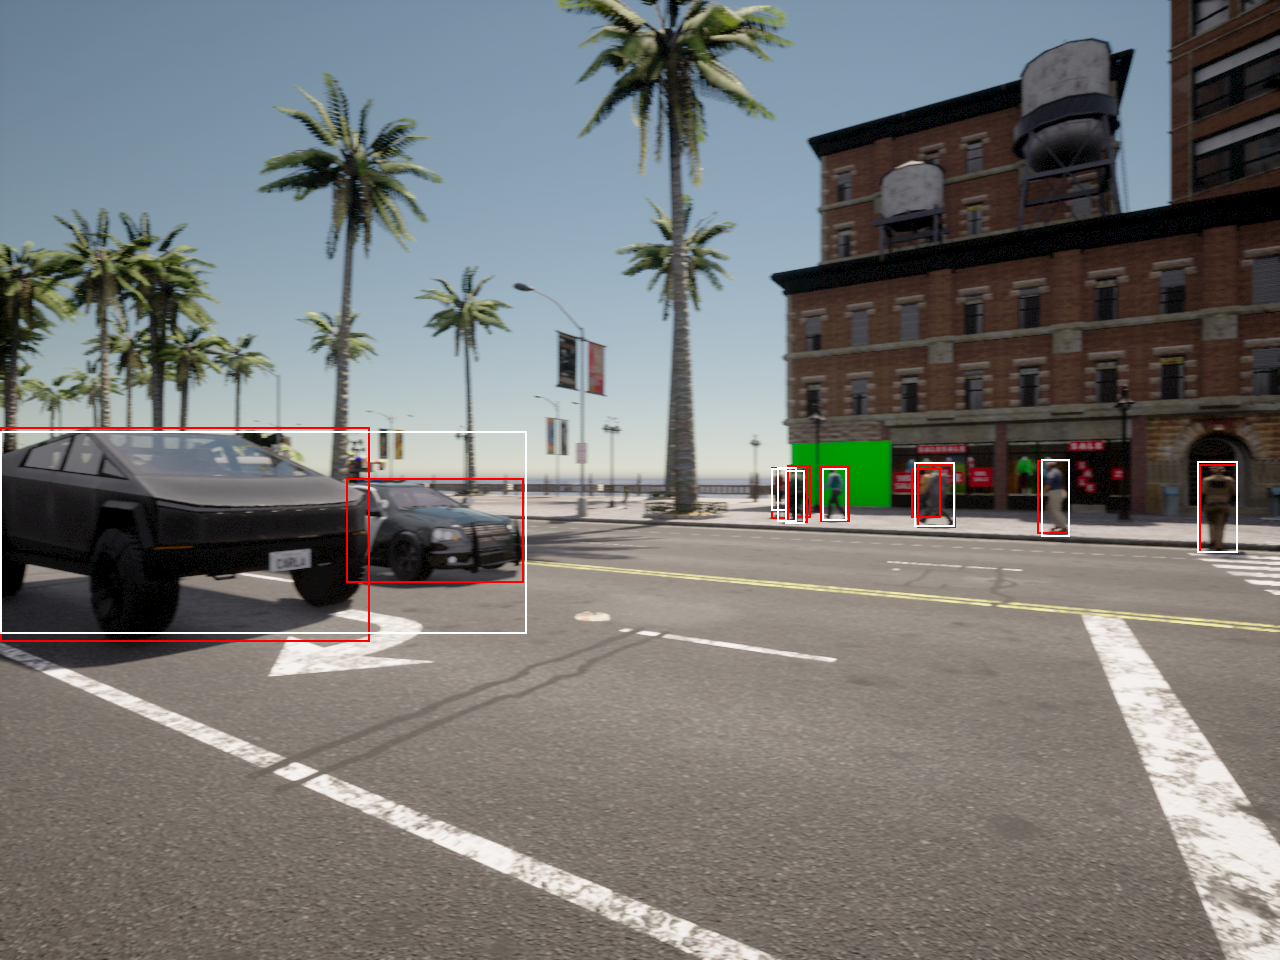

In [29]:
display(x_pil)

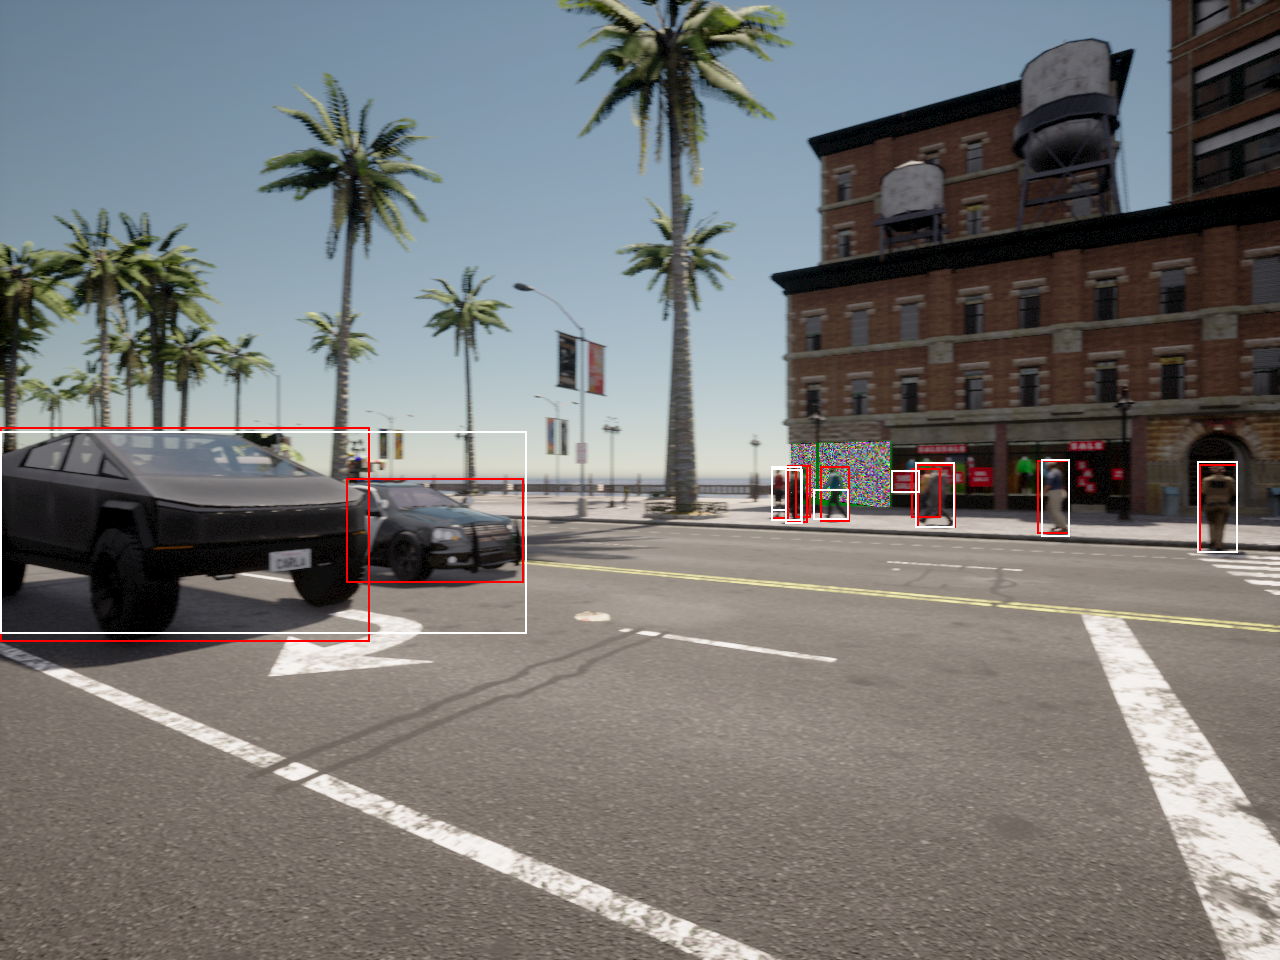

In [30]:
display(x_adv_pil)

### Finishing the Experiment
If you'd like to run the experiment over the rest of the data examples, simply call `s.evaluate()`. Doing so will complete the rest of the evaluation, prepare and finalize the results, and write the results JSON to the Armory scenario output directory.

If instead you'd like to finish the experiment at its current step, call `s.finalize_results()` which logs the experiment results to console.

In [31]:
s.finalize_results()

2022-11-09 13:29:05 14m8s SUCCESS  armory.instrument.config:_write:224 benign_carla_od_AP_per_class on benign examples w.r.t. ground truth labels: {'mean': 0.89500000000000002, 'class': {1: 0.93999999999999995, 2: 0.84999999999999998}}
2022-11-09 13:29:05 14m8s SUCCESS  armory.instrument.config:_write:224 adversarial_carla_od_AP_per_class on adversarial examples w.r.t. ground truth labels: {'mean': 0.745, 'class': {1: 0.76000000000000001, 2: 0.72999999999999998}}
2022-11-09 13:29:05 14m8s SUCCESS  armory.instrument.config:_write:224 benign_mean_carla_od_disappearance_rate on benign examples w.r.t. ground truth labels: 30.00%
2022-11-09 13:29:05 14m8s SUCCESS  armory.instrument.config:_write:224 adversarial_mean_carla_od_disappearance_rate on adversarial examples w.r.t. ground truth labels: 40.00%
2022-11-09 13:29:05 14m8s SUCCESS  armory.instrument.config:_write:224 benign_mean_carla_od_hallucinations_per_image on benign examples w.r.t. ground truth labels: 1.0
2022-11-09 13:29:05 14m8

Afterwards, you can then call `s.save()` to write the results JSON to the Armory output directory. Alternatively, if you'd like to return the results as a Python dictionary, call `s.prepare_results()`.

In [32]:
results_dict = s.prepare_results()
print(results_dict.keys())

dict_keys(['armory_version', 'config', 'results', 'timestamp'])


In [33]:
print(results_dict["results"])

{'benign_carla_od_AP_per_class': [{'mean': 0.89500000000000002, 'class': {1: 0.93999999999999995, 2: 0.84999999999999998}}], 'adversarial_carla_od_AP_per_class': [{'mean': 0.745, 'class': {1: 0.76000000000000001, 2: 0.72999999999999998}}], 'benign_mean_carla_od_disappearance_rate': [0.30000000000000004], 'adversarial_mean_carla_od_disappearance_rate': [0.40000000000000002], 'benign_mean_carla_od_hallucinations_per_image': [1.0], 'adversarial_mean_carla_od_hallucinations_per_image': [2.0], 'benign_mean_carla_od_misclassification_rate': [0.0], 'adversarial_mean_carla_od_misclassification_rate': [0.0], 'benign_mean_carla_od_true_positive_rate': [0.69999999999999996], 'adversarial_mean_carla_od_true_positive_rate': [0.59999999999999998], 'perturbation_mean_l0': [14665.0], 'adversarial_carla_od_AP_per_class_wrt_benign_preds': [{'mean': 0.47999999999999998, 'class': {1: 0.54000000000000004, 2: 0.41999999999999998}}], 'adversarial_mean_carla_od_disappearance_rate_wrt_benign_preds': [0.75], 'a

In [34]:
s.save()

2022-11-09 13:29:05 14m8s INFO     armory.scenarios.scenario:save:436 Saving evaluation results to path /armory/outputs/2022-11-09T130708.219154/CarlaObjectDetectionTask_1668000191.json inside container.
